In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-04_13-14_20180601_20191231_lock_periods_by_2.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.005823627287853577

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

GC       0.25
NQ       0.25
ES       0.25
YM       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    25120.4
GC    12569.0
NQ    22455.4
YM    24610.8
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

84755.59999999999

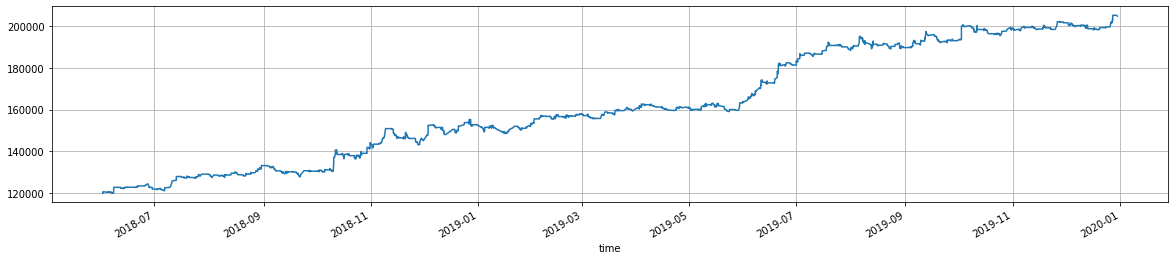

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     276
 GC     550
 NQ    1226
 YM     352
 Name: action, dtype: int64,
 2404)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.669903
 GC    1.334951
 NQ    2.975728
 YM    0.854369
 Name: action, dtype: float64,
 5.834951456310679)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     579.6
GC    1331.0
NQ    2574.6
YM     739.2
Name: commission, dtype: float64

In [16]:
df.commission.sum()

5224.4

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,45.71,515.16,-262.55,1.96,48.53,275.0
NQ,0.41,36.63,446.46,-245.62,1.82,38.13,613.0
YM,0.44,139.83,774.33,-365.17,2.12,136.21,176.0
ES,0.46,182.03,1017.68,-540.69,1.88,176.16,138.0
total,0.42,70.51,585.42,-297.49,1.97,73.33,1202.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.088711,0.104934,0.359897,0.656318
GC,-0.088711,1.000000,0.046058,0.043273,0.321179
NQ,0.104934,0.046058,1.000000,0.200214,0.619157
YM,0.359897,0.043273,0.200214,1.000000,0.692695
total,0.656318,0.321179,0.619157,0.692695,1.000000


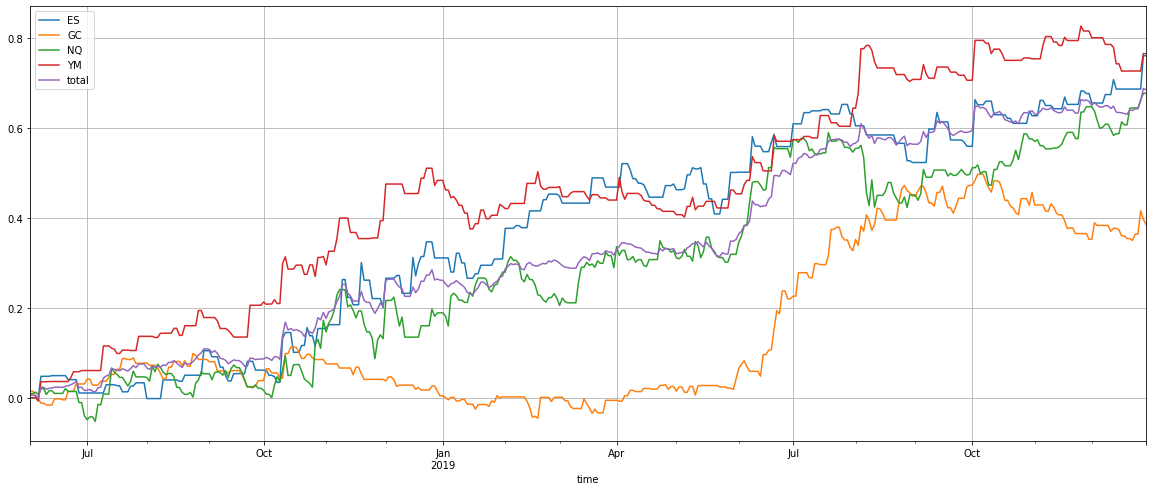

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

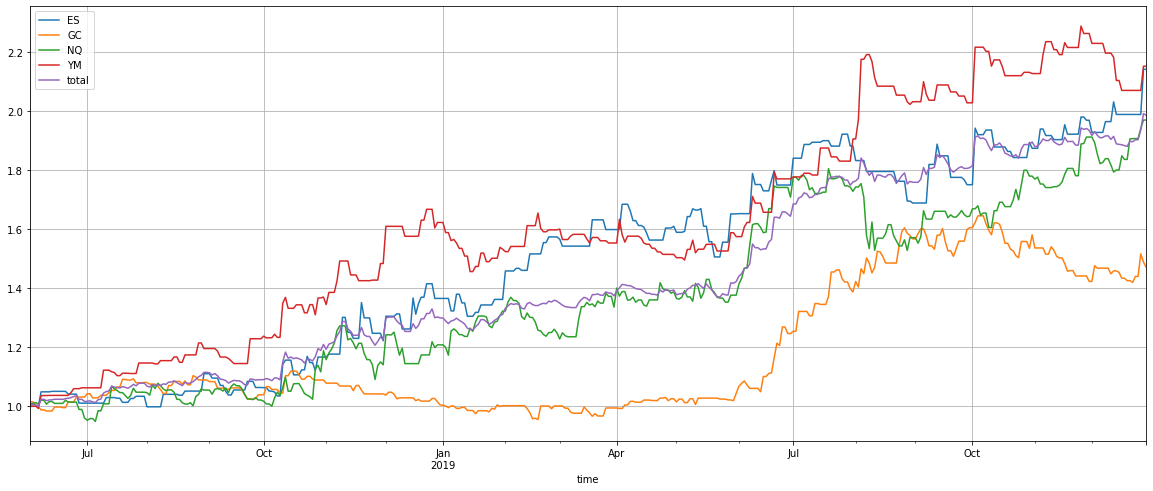

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.593191,0.265932,0.513667,0.597851,0.521038
Cumulative returns,1.141370,0.470392,0.969406,1.151620,0.985109
Annual volatility,0.308376,0.203527,0.295496,0.259832,0.157958
Sharpe ratio,1.660839,1.259101,1.549356,1.931148,2.734947
Calmar ratio,4.889075,1.815223,3.344573,4.726061,8.331458
Stability,0.939567,0.596884,0.936376,0.926259,0.967731
Max drawdown,-0.121330,-0.146501,-0.153582,-0.126501,-0.062539
Omega ratio,1.641947,1.328046,1.372649,1.757339,1.742579
Sortino ratio,3.554487,2.524968,2.780251,4.521790,6.015267
Skew,2.363980,1.764650,1.066534,2.707761,2.011036


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.08,3.14,-3.93,6.26,1.64
2018-07-31,2.29,4.78,9.06,7.90,6.10
2018-08-31,7.41,0.79,0.69,4.27,3.41
2018-09-30,-4.22,-4.62,-3.18,2.77,-2.26
2018-10-31,9.69,4.82,16.36,11.49,10.96
2018-11-30,4.74,-4.32,-4.02,8.29,1.39
2018-12-31,11.72,-3.62,5.92,9.37,5.96
2019-01-31,-0.24,-0.22,9.48,-5.59,0.90
2019-02-28,15.53,-0.09,-5.62,4.28,3.43


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES       114.0
GC        47.0
NQ        97.0
YM       115.0
total     99.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 21:00:00,ES,BUY,2893.75,3283.30
2018-11-09 09:08:00,ES,SELL,2796.25,3170.80
2019-08-05 21:19:30,YM,BUY,25629.00,3120.80
2018-10-10 21:49:30,ES,BUY,2814.50,3095.80
2019-06-20 03:04:00,GC,SELL,1392.00,3065.16
...,...,...,...,...
2018-11-13 19:11:00,ES,SELL,2731.00,-1166.70
2018-12-11 20:44:00,ES,BUY,2649.25,-1166.70
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.20


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-12-03,0.067777,-0.003656,0.088913,0.084860,0.059474
2018-10-10,0.103193,0.000000,0.025527,0.093193,0.055478
2019-10-02,0.109443,0.010849,0.000000,0.092860,0.053288
2019-06-20,0.018193,0.046860,0.045860,0.081860,0.048193
2019-06-10,0.082360,0.000000,0.044413,0.054220,0.045248
...,...,...,...,...,...
2019-08-12,0.000000,0.012677,-0.059060,-0.025473,-0.017964
2018-11-13,-0.038890,0.000000,-0.037420,0.000000,-0.019078
2018-11-21,-0.038473,-0.011828,-0.028780,0.000000,-0.019770
